<a href="https://colab.research.google.com/github/Cylick-d/A-Two-Stage-Parameter-Efficient-Fine-Tuning-Framework-LoRA-/blob/main/stage1_layer_selection%26stage2_precision_lora_ini.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
import os

# 挂载 Drive 到 /content/drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


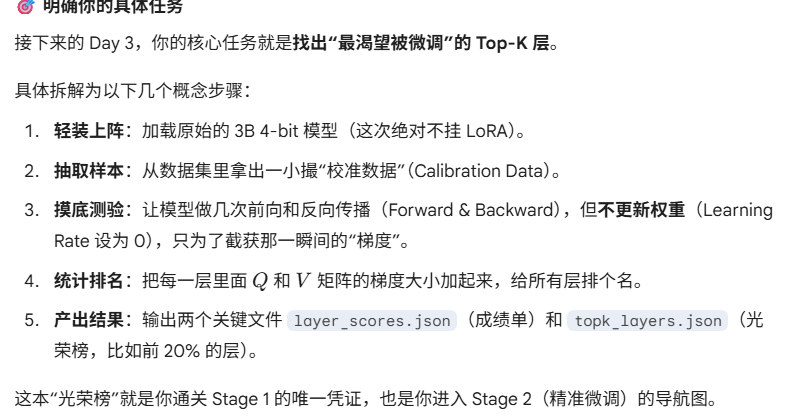

In [ ]:
# 2. 精准指向你的真实项目目录
BASE_DIR = '/content/drive/MyDrive/Colab Notebooks/COMP9991/COMP9991_PEFT'

# 3. 在项目目录下设定模型输出和数据缓存的路径
OUTPUT_DIR = os.path.join(BASE_DIR, 'experiments', 'qwen-3b-lora-baseline')
DATA_CACHE_DIR = os.path.join(BASE_DIR, 'dataset_cache')
# 设定专门的模型缓存路径
MODEL_CACHE_DIR = os.path.join(BASE_DIR, 'model_cache')

# 创建文件夹（如果不存在的话）
os.makedirs(MODEL_CACHE_DIR, exist_ok=True)
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(DATA_CACHE_DIR, exist_ok=True)

print(f"✅ Drive 挂载成功！")
print(f"📂 模型缓存路径: {MODEL_CACHE_DIR}")
print(f"📂 模型输出路径: {OUTPUT_DIR}")
print(f"📂 数据缓存路径: {DATA_CACHE_DIR}")

# ==========================================
# 0. 设定专属输出目录
# ==========================================
STAGE1_OUTPUT_DIR = os.path.join(BASE_DIR, 'experiments', 'stage1_layer_selection')
os.makedirs(STAGE1_OUTPUT_DIR, exist_ok=True)
print(f"📂 Stage 1 输出路径已就绪: {STAGE1_OUTPUT_DIR}")

STAGE2_FA_OUTPUT_DIR = os.path.join(BASE_DIR, 'experiments', 'stage2_lorafa_top20')
os.makedirs(STAGE2_FA_OUTPUT_DIR, exist_ok=True)
# 🌟 新建一个目录存 Stage 2 的结果，不和 Baseline 混淆
STAGE2_OUTPUT_DIR = os.path.join(BASE_DIR, 'experiments', 'stage2_lora_top20')
os.makedirs(STAGE2_OUTPUT_DIR, exist_ok=True)

✅ Drive 挂载成功！
📂 模型缓存路径: /content/drive/MyDrive/Colab Notebooks/COMP9991/COMP9991_PEFT/model_cache
📂 模型输出路径: /content/drive/MyDrive/Colab Notebooks/COMP9991/COMP9991_PEFT/experiments/qwen-3b-lora-baseline
📂 数据缓存路径: /content/drive/MyDrive/Colab Notebooks/COMP9991/COMP9991_PEFT/dataset_cache


In [ ]:
!pip install -q -U transformers peft accelerate datasets trl bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 110.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 520.7/520.7 kB 49.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 528.8/528.8 kB 52.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.7/60.7 MB 43.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.6/47.6 MB 45.5 MB/s eta 0:00:00


In [ ]:
pip install -U bitsandbytes>=0.46.1

In [ ]:
import torch
import json
import os
import numpy as np
from datasets import load_dataset
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
# ==========================================
# 1. 加载 4-bit 原始模型
# ==========================================
model_id = "Qwen/Qwen2.5-3B"
print("🚀 正在从 Drive 缓存加载 4-bit 模型...")

tokenizer = AutoTokenizer.from_pretrained(model_id, cache_dir=MODEL_CACHE_DIR)
tokenizer.pad_token = tokenizer.eos_token

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_use_double_quant=False,
    bnb_4bit_quant_type="nf4",
)

# 使用 L4 支持的 SDPA 加速，且不挂 LoRA
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    quantization_config=bnb_config,
    device_map="auto",
    attn_implementation="sdpa",
    cache_dir=MODEL_CACHE_DIR
)
model.config.use_cache = False
model.gradient_checkpointing_enable()

model.train() # 🌟 关键：开启 train 模式才能反向传播计算梯度

🚀 正在从 Drive 缓存加载 4-bit 模型...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading weights:   0%|          | 0/434 [00:00<?, ?it/s]

Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(151936, 2048)
    (layers): ModuleList(
      (0-35): 36 x Qwen2DecoderLayer(
        (self_attn): Qwen2Attention(
          (q_proj): Linear4bit(in_features=2048, out_features=2048, bias=True)
          (k_proj): Linear4bit(in_features=2048, out_features=256, bias=True)
          (v_proj): Linear4bit(in_features=2048, out_features=256, bias=True)
          (o_proj): Linear4bit(in_features=2048, out_features=2048, bias=False)
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear4bit(in_features=2048, out_features=11008, bias=False)
          (up_proj): Linear4bit(in_features=2048, out_features=11008, bias=False)
          (down_proj): Linear4bit(in_features=11008, out_features=2048, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): Qwen2RMSNorm((2048,), eps=1e-06)
        (post_attention_layernorm): Qwen2RMSNorm((2048,), eps=1e-06)
      )
    )
    (norm): Qwen2RMSNorm

In [ ]:
# ==========================================
# 2. 准备 Calibration Data (抽 512 条)
# ==========================================
print("🚀 正在加载 Dolly 校准数据...")
calib = load_dataset("databricks/databricks-dolly-15k", split="train[:512]", cache_dir=DATA_CACHE_DIR)

def format_dolly(example):
    instruction = example['instruction']
    context = example.get('context', '')
    response = example['response']
    if context:
        return f"Instruction:\n{instruction}\n\nContext:\n{context}\n\nResponse:\n{response}"
    return f"Instruction:\n{instruction}\n\nResponse:\n{response}"

texts = [format_dolly(x) for x in calib]

# ==========================================
# 3. 定位所有的 Q 和 V 矩阵参数
# ==========================================
layers = model.model.layers
n_layers = len(layers)
print(f"🔍 探测到模型共有 {n_layers} 层 Transformer Block")

qv_params = []
for i, layer in enumerate(layers):
    q = layer.self_attn.q_proj
    v = layer.self_attn.v_proj
    qv_params.append((i, q.weight, v.weight))

# 初始化一个存分数的张量 (全0)
layer_scores = torch.zeros(n_layers, device=model.device)

# ==========================================
# 4. 跑 Forward + Backward，累积梯度范数
# ==========================================
def make_batch(text_batch, max_len=512):
    toks = tokenizer(
        text_batch, return_tensors="pt", padding=True, truncation=True, max_length=max_len
    )
    toks = {k: v.to(model.device) for k, v in toks.items()}
    toks["labels"] = toks["input_ids"].clone()
    return toks

# 创建一个假的 SGD 优化器，学习率为 0，保证模型权重绝对不被修改！
optimizer = torch.optim.SGD([p for _, q, v in qv_params for p in (q, v)], lr=0.0)

bs = 2
num_steps = 32 # 跑 32 步，每步 batch_size 2，共看 64 条数据，足够测出敏感度排序了
print(f"🔥 开始进行梯度捕获 (共 {num_steps} 步)...")

for step in range(num_steps):
    batch_texts = texts[step * bs : (step + 1) * bs]
    batch = make_batch(batch_texts)

    optimizer.zero_grad(set_to_none=True)
    out = model(**batch)
    loss = out.loss
    loss.backward() # 🌟 核心动作：反向传播计算梯度！

    # 统计这一步里，每层 Q 和 V 的 Gradient Norm
    for i, qw, vw in qv_params:
        gq = 0.0 if qw.grad is None else qw.grad.detach().float().norm(p=2).item()
        gv = 0.0 if vw.grad is None else vw.grad.detach().float().norm(p=2).item()
        layer_scores[i] += (gq + gv)

    if (step + 1) % 8 == 0:
        print(f"   [Step {step + 1}/{num_steps}] 嗅探 Loss = {loss.item():.4f}")

# 归一化求平均
scores = (layer_scores / num_steps).detach().cpu().tolist()

# ==========================================
# 5. 输出 Top-K 结果至云盘
# ==========================================
k_ratio = 0.2 # 设定选取最敏感的前 20% 层
k = max(1, int(n_layers * k_ratio))

# 降序排列获取层索引
idx = np.argsort(scores)[::-1]
topk = idx[:k].tolist()

print("\n🎯 选层结果出炉！")
print(f"Top {k_ratio*100}% 最敏感的层索引为: {topk}")

# 写入 JSON
scores_path = os.path.join(STAGE1_OUTPUT_DIR, "layer_scores.json")
topk_path = os.path.join(STAGE1_OUTPUT_DIR, "topk_layers.json")

with open(scores_path, "w") as f:
    json.dump({"scores": scores}, f, indent=2)

with open(topk_path, "w") as f:
    json.dump({"k_ratio": k_ratio, "topk_layers": topk}, f, indent=2)

print(f"✅ 文件已保存至:\n - {scores_path}\n - {topk_path}")

🚀 正在加载 Dolly 校准数据...


README.md: 0.00B [00:00, ?B/s]

🔍 探测到模型共有 36 层 Transformer Block
🔥 开始进行梯度捕获 (共 32 步)...
   [Step 8/32] 嗅探 Loss = 3.3565
   [Step 16/32] 嗅探 Loss = 4.0636
   [Step 24/32] 嗅探 Loss = 2.6238
   [Step 32/32] 嗅探 Loss = 3.2804

🎯 选层结果出炉！
Top 20.0% 最敏感的层索引为: [35, 34, 33, 32, 31, 30, 29]
✅ 文件已保存至:
 - /content/drive/MyDrive/Colab Notebooks/COMP9991/COMP9991_PEFT/experiments/stage1_layer_selection/layer_scores.json
 - /content/drive/MyDrive/Colab Notebooks/COMP9991/COMP9991_PEFT/experiments/stage1_layer_selection/topk_layers.json


stage2

In [ ]:
import torch
import json
import os
from datasets import load_dataset
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from peft import LoraConfig, get_peft_model
from trl import SFTTrainer, SFTConfig

STAGE1_DIR = os.path.join(BASE_DIR, 'experiments', 'stage1_layer_selection')
# 动态读取你刚才跑出的 topk_layers
topk_path = os.path.join(STAGE1_DIR, "topk_layers.json")
with open(topk_path, "r") as f:
    stage1_data = json.load(f)
topk_layers = stage1_data["topk_layers"]
print(f"🎯 成功读取目标层: {topk_layers}")

# ==========================================
# 1. 核心创新点：动态生成 Target Modules 列表
# ==========================================
# Qwen2.5 的注意力层路径标准格式: model.layers.{i}.self_attn.q_proj
custom_target_modules = []
for i in topk_layers:
    custom_target_modules.append(f"model.layers.{i}.self_attn.q_proj")
    custom_target_modules.append(f"model.layers.{i}.self_attn.v_proj")

print(f"🎯 LoRA 挂载目标 (共 {len(custom_target_modules)} 个模块):")
for m in custom_target_modules[:4]:
    print(f"   - {m}")
print("   ... (其余省略)")

# ==========================================
# 2. 加载模型与 Tokenizer (复用 L4 提速经验)
# ==========================================
model_id = "Qwen/Qwen2.5-3B"
tokenizer = AutoTokenizer.from_pretrained(model_id, cache_dir=MODEL_CACHE_DIR)
tokenizer.pad_token = tokenizer.eos_token

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_use_double_quant=False,
    bnb_4bit_quant_type="nf4",
)

model = AutoModelForCausalLM.from_pretrained(
    model_id,
    quantization_config=bnb_config,
    device_map="auto",
    attn_implementation="sdpa", # 沿用提速方案
    cache_dir=MODEL_CACHE_DIR
)
model.config.use_cache = False
model.gradient_checkpointing_enable()

# ==========================================
# 3. 挂载精准 LoRA (魔法发生的地方)
# ==========================================
lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=custom_target_modules, # 🌟 核心变化：传入我们定制的特定层列表！
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)


model = get_peft_model(model, lora_config)
print("\n📊 核心对比数据请注意看这里：")
model.print_trainable_parameters()

# ==========================================
# 4. 数据集准备 (前 5000 条)
# ==========================================
print("\n🚀 正在加载 Dolly 15k subset...")
dataset = load_dataset("databricks/databricks-dolly-15k", split="train[:5000]", cache_dir=DATA_CACHE_DIR)

def format_dolly(example):
    instruction = example['instruction']
    context = example.get('context', '')
    response = example['response']
    if context:
        return f"Instruction:\n{instruction}\n\nContext:\n{context}\n\nResponse:\n{response}"
    return f"Instruction:\n{instruction}\n\nResponse:\n{response}"

# ==========================================
# 5. 开启 1000 步训练
# ==========================================
training_args = SFTConfig(
    output_dir=STAGE2_OUTPUT_DIR,
    per_device_train_batch_size=4, # L4 显存够大
    gradient_accumulation_steps=2,
    max_steps=1000,
    save_steps=200,
    logging_steps=50,
    optim="paged_adamw_32bit",
    learning_rate=2e-4,
    fp16=False,
    bf16=True,
    report_to="none",
    max_length=512
)

trainer = SFTTrainer(
    model=model,
    train_dataset=dataset,
    formatting_func=format_dolly,
    processing_class=tokenizer,
    args=training_args,
)

print("\n🚀 启动 Stage 2：精准选层 LoRA 训练...")
trainer.train()

# 强制保存最终权重
trainer.save_model(STAGE2_OUTPUT_DIR)
tokenizer.save_pretrained(STAGE2_OUTPUT_DIR)
print(f"🎉 Stage 2 训练完成！权重已保存至: {STAGE2_OUTPUT_DIR}")

🎯 成功读取目标层: [35, 34, 33, 32, 31, 30, 29]
🎯 LoRA 挂载目标 (共 14 个模块):
   - model.layers.35.self_attn.q_proj
   - model.layers.35.self_attn.v_proj
   - model.layers.34.self_attn.q_proj
   - model.layers.34.self_attn.v_proj
   ... (其余省略)


Loading weights:   0%|          | 0/434 [00:00<?, ?it/s]


📊 核心对比数据请注意看这里：
trainable params: 716,800 || all params: 3,086,655,488 || trainable%: 0.0232

🚀 正在加载 Dolly 15k subset...


Applying formatting function to train dataset:   0%|          | 0/5000 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/5000 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/5000 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/5000 [00:00<?, ? examples/s]

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': None, 'pad_token_id': 151643}.



🚀 启动 Stage 2：精准选层 LoRA 训练...


Step,Training Loss
50,2.031212
100,1.891186
150,1.855265
200,1.860175
250,1.879236
300,1.904886
350,1.820513
400,1.841253
450,1.841273
500,1.820481


config.json:   0%|          | 0.00/683 [00:00<?, ?B/s]

🎉 Stage 2 训练完成！权重已保存至: /content/drive/MyDrive/Colab Notebooks/COMP9991/COMP9991_PEFT/experiments/stage2_lora_top20


In [ ]:
#LoraFA的实验（选top 20%+冻结A）
import torch
import json
import os
from datasets import load_dataset
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from peft import LoraConfig, get_peft_model
from trl import SFTTrainer, SFTConfig

STAGE1_DIR = os.path.join(BASE_DIR, 'experiments', 'stage1_layer_selection')
# 动态读取你刚才跑出的 topk_layers
topk_path = os.path.join(STAGE1_DIR, "topk_layers.json")
with open(topk_path, "r") as f:
    stage1_data = json.load(f)
topk_layers = stage1_data["topk_layers"]
print(f"🎯 成功读取目标层: {topk_layers}")

# ==========================================
# 1. 核心创新点：动态生成 Target Modules 列表
# ==========================================
# Qwen2.5 的注意力层路径标准格式: model.layers.{i}.self_attn.q_proj
custom_target_modules = []
for i in topk_layers:
    custom_target_modules.append(f"model.layers.{i}.self_attn.q_proj")
    custom_target_modules.append(f"model.layers.{i}.self_attn.v_proj")

print(f"🎯 LoRA 挂载目标 (共 {len(custom_target_modules)} 个模块):")
for m in custom_target_modules[:4]:
    print(f"   - {m}")
print("   ... (其余省略)")

# ==========================================
# 2. 加载模型与 Tokenizer (复用 L4 提速经验)
# ==========================================
model_id = "Qwen/Qwen2.5-3B"
tokenizer = AutoTokenizer.from_pretrained(model_id, cache_dir=MODEL_CACHE_DIR)
tokenizer.pad_token = tokenizer.eos_token

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_use_double_quant=False,
    bnb_4bit_quant_type="nf4",
)

model = AutoModelForCausalLM.from_pretrained(
    model_id,
    quantization_config=bnb_config,
    device_map="auto",
    attn_implementation="sdpa", # 沿用提速方案
    cache_dir=MODEL_CACHE_DIR
)
model.config.use_cache = False
model.gradient_checkpointing_enable()

# ==========================================
# 3. 挂载精准 LoRA ——LoRA-FA
# ==========================================
lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=custom_target_modules, # 🌟 核心变化：传入我们定制的特定层列表！
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)
model = get_peft_model(model, lora_config)

# 🌟 核心魔法：LoRA-FA (Frozen-A)
# 遍历模型的所有参数，只要名字里带 "lora_A"，就剥夺它的训练权！
for name, param in model.named_parameters():
    if "lora_A" in name:
        param.requires_grad = False

print("\n📊 LoRA-FA 极限压缩后的参数量：")
model.print_trainable_parameters()

# ==========================================
# 4. 数据集准备 (前 5000 条)
# ==========================================
print("\n🚀 正在加载 Dolly 15k subset...")
dataset = load_dataset("databricks/databricks-dolly-15k", split="train[:5000]", cache_dir=DATA_CACHE_DIR)

def format_dolly(example):
    instruction = example['instruction']
    context = example.get('context', '')
    response = example['response']
    if context:
        return f"Instruction:\n{instruction}\n\nContext:\n{context}\n\nResponse:\n{response}"
    return f"Instruction:\n{instruction}\n\nResponse:\n{response}"

# ==========================================
# 5. 开启 1000 步训练
# ==========================================
training_args = SFTConfig(
    output_dir=STAGE2_FA_OUTPUT_DIR,
    per_device_train_batch_size=4, # L4 显存够大
    gradient_accumulation_steps=2,
    max_steps=1000,
    save_steps=200,
    logging_steps=50,
    optim="paged_adamw_32bit",
    learning_rate=2e-4,
    fp16=False,
    bf16=True,
    report_to="none",
    max_length=512
)

trainer = SFTTrainer(
    model=model,
    train_dataset=dataset,
    formatting_func=format_dolly,
    processing_class=tokenizer,
    args=training_args,
)

print("\n🚀 启动 Stage 2：精准选层 LoRA 训练...")
trainer.train()

# 强制保存最终权重
trainer.save_model(STAGE2_FA_OUTPUT_DIR)
tokenizer.save_pretrained(STAGE2_FA_OUTPUT_DIR)
print(f"🎉 Stage 2 训练完成！权重已保存至: {STAGE2_FA_OUTPUT_DIR}")

🎯 成功读取目标层: [35, 34, 33, 32, 31, 30, 29]
🎯 LoRA 挂载目标 (共 14 个模块):
   - model.layers.35.self_attn.q_proj
   - model.layers.35.self_attn.v_proj
   - model.layers.34.self_attn.q_proj
   - model.layers.34.self_attn.v_proj
   ... (其余省略)


Loading weights:   0%|          | 0/434 [00:00<?, ?it/s]


📊 LoRA-FA 极限压缩后的参数量：
trainable params: 258,048 || all params: 3,086,655,488 || trainable%: 0.0084

🚀 正在加载 Dolly 15k subset...


The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': None, 'pad_token_id': 151643}.



🚀 启动 Stage 2：精准选层 LoRA 训练...


Step,Training Loss


Step,Training Loss
50,2.075792
100,2.041627
150,2.000472
200,1.985593
250,2.005959
300,2.024720
350,1.938616
400,1.948019
450,1.945720
500,1.937087


🎉 Stage 2 训练完成！权重已保存至: /content/drive/MyDrive/Colab Notebooks/COMP9991/COMP9991_PEFT/experiments/stage2_lorafa_top20
